In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import json
from pprint import pprint

def save_fig(fig, name):
    fig.savefig("graphs/{}.png".format(name), format="png", dpi=500)
    fig.savefig("graphs/{}.pdf".format(name), format="pdf", dpi=500)

In [2]:
def load_json(path):
    with open(path) as f:
        data = json.load(f)
    timings = []
    for d in data["datapoints"]:
        s = d["setting"]
        t = list(map(lambda x: (x["computationTime"], x["mpiTime"]),
                       sorted(d["data"]["workers"], key=lambda x: x["rank"])))
        for time in t:
            timings.append(time)
    return timings

In [3]:
def mean_confidence(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1+ confidence) / 2., n - 1)
    return m, h

4 OpenMP speedup factor 1.5480345002059392
4 MPI speedup factor: 3.494955683180427


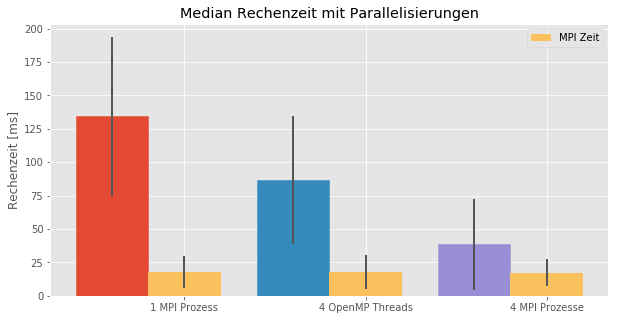

In [4]:
normalT = load_json("./data/data_parallel_normal.json")
ompT = load_json("./data/data_parallel_4_OpenMP.json")
mpiT = load_json("./data/data_parallel_4_MPI.json")
mpi2T = load_json("./data/data_parallel_2_MPI.json")


def stat(data):
    a, b = zip(*data)
    a, b = np.asarray(a) / 1e3, np.asarray(b) / 1e3
    #m, err = mean_confidence(a, .99)
    #m2, err2 = mean_confidence(b, .99)
    #return m, err, m2, err2
    return np.mean(a), np.std(a), np.mean(b), np.std(b)

normal, normalErr, normalMPI, normalMPIerr = stat(normalT)
omp, ompErr, ompMPI, ompMPIerr = stat(ompT)
mpi, mpiErr, mpiMPI, mpiMPIerr = stat(mpiT)


x_ticks = ["1 MPI Prozess", "4 OpenMP Threads",  "4 MPI Prozesse"]
x = np.arange(len(x_ticks))
y = (normal, omp, mpi)
yerr = (normalErr, ompErr, mpiErr)


fig, ax = plt.subplots(figsize=(10,5))
total_width = 0.8
ind_width = total_width / 2
alteration = np.arange(-(total_width / 2), total_width/2, ind_width)

barlist = ax.bar(alteration[0] + x, y, align='center', width=ind_width)

barlist[0].set_color('C0')
barlist[1].set_color('C1')
barlist[2].set_color('C2')


yMPI = (normalMPI, ompMPI, mpiMPI)
yMPIErr = (normalMPIerr, ompMPIerr, mpiMPIerr)
ax.bar(alteration[1] + x, yMPI, align='center', color='#FBC15E', width=ind_width, label='MPI Zeit')


ax.errorbar(alteration[0] + x, y, yerr=yerr, color='#555555', ls='none', lw = 2, capthick = 2)
ax.errorbar(alteration[1] + x, yMPI, yerr=yMPIErr, color='#555555', ls='none', lw = 2, capthick = 2)
ax.set_ylabel('Rechenzeit [ms]')
ax.set_title('Median Rechenzeit mit Parallelisierungen')

ax.set_xticks(np.arange(len(x_ticks)))
ax.set_xticklabels(x_ticks)
ax.legend()
#plt.yscale('log')
#save_fig(fig, 'parallelism')

print('4 OpenMP speedup factor', normal / omp)
print('4 MPI speedup factor:', normal / mpi)

plt.show()


In [5]:
from scipy.stats import gaussian_kde
from math import floor

def histogram(ax, y_data1, 
              x_label="", y_label="", title=""):
    num_bins = 30
    
    # draw histogram
    #_, _, y1_patches = ax.hist(y_data1, num_bins, density=1, alpha=1)

    #y1_color = y1_patches[0].get_facecolor()
    ax.set(xlabel=x_label, ylabel=y_label, title=title)
    #ax.legend()
    ax.grid(True)

    def drawKDE(ax, data, color):
        # plot kernel density estimate
        density = gaussian_kde(data)
        xs = np.linspace(-0.1, data.max(), 200)
        density.covariance_factor = lambda : .25
        density._compute_covariance()
        ys = density(xs)

        alpha=.75
        kde_line = ax.plot(xs, ys, alpha=alpha)
        kde_line[0].set_color(color)
        # TODO: Find a better way to do this
        ys[0] = 0
        ys[-1] = 0
        
        kde_fill = ax.fill(xs, ys, alpha=alpha)
        kde_fill[0].set_color(color)

    drawKDE(ax, y_data1, '#E24A33')

    #  median
    y1_mean = y_data1.mean()
    y1_max = y_data1.max()
    
    def drawLine(ax, x, label, y_offset, color, style):
        ax.axvline(x, linestyle=style, lw=2, color=color)
        _, max_ = plt.ylim()
       # plt.text(x + x / num_bins, 
       #      max_ - max_* y_offset/ 10, 
    #     label + ': {:.2f} s'.format(x))
        
    drawLine(ax, y1_mean, "$N_{mean}$", 2, '#348ABD', 'dashed')
    drawLine(ax, y1_max, "$N_{max}$", 2, '#348ABD', 'solid')

    # fig.savefig("distribution.svg", format="svg")

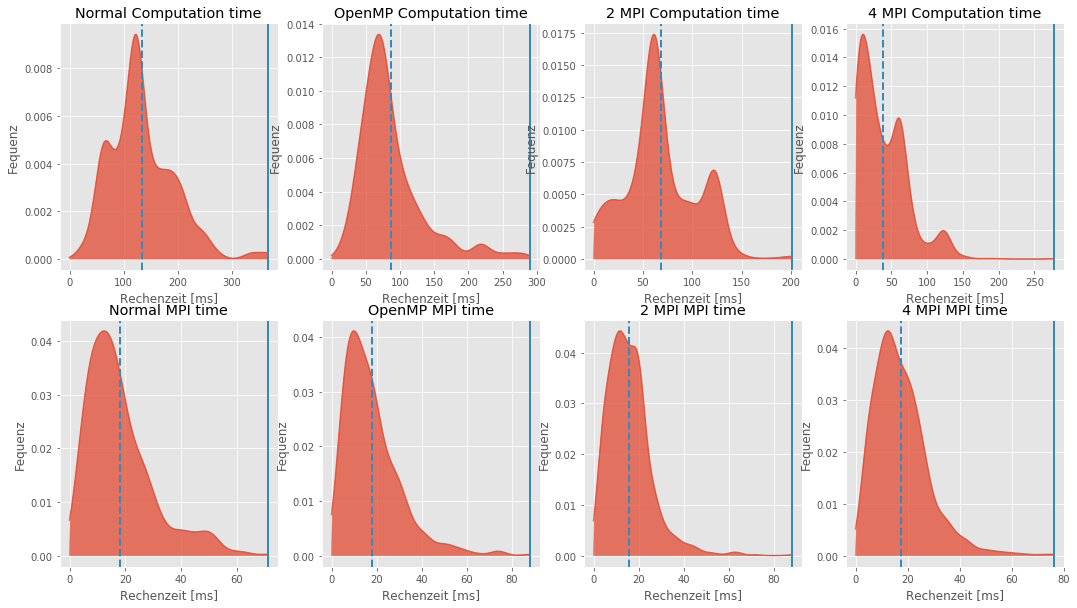

In [6]:
normalCT, normalMPI = zip(*normalT)
ompCT, ompMPI = zip(*ompT)
mpiCT, mpiMPI = zip(*mpiT)
mpi2CT, mpi2MPI = zip(*mpi2T)

normalCT, normalMPI = np.asarray(normalCT) / 1e3, np.asarray(normalMPI) / 1e3
ompCT, ompMPI = np.asarray(ompCT) / 1e3, np.asarray(ompMPI) / 1e3
mpiCT, mpiMPI = np.asarray(mpiCT) / 1e3, np.asarray(mpiMPI) / 1e3
mpi2CT, mpi2MPI = np.asarray(mpi2CT) / 1e3, np.asarray(mpi2MPI) / 1e3


fig, axs = plt.subplots(2, 4, figsize=(18,10))
histogram(axs[0,0], normalCT, 'Rechenzeit [ms]', 'Fequenz', "Normal Computation time")
histogram(axs[0,1], ompCT, 'Rechenzeit [ms]', 'Fequenz', "OpenMP Computation time")
histogram(axs[0,2], mpi2CT, 'Rechenzeit [ms]', 'Fequenz', "2 MPI Computation time")
histogram(axs[0,3], mpiCT, 'Rechenzeit [ms]', 'Fequenz', "4 MPI Computation time")
histogram(axs[1,0], normalMPI, 'Rechenzeit [ms]', 'Fequenz', "Normal MPI time")
histogram(axs[1,1], ompMPI, 'Rechenzeit [ms]', 'Fequenz', "OpenMP MPI time")
histogram(axs[1,2], mpi2MPI, 'Rechenzeit [ms]', 'Fequenz', "2 MPI MPI time")
histogram(axs[1,3], mpiMPI, 'Rechenzeit [ms]', 'Fequenz', "4 MPI MPI time")

plt.show()


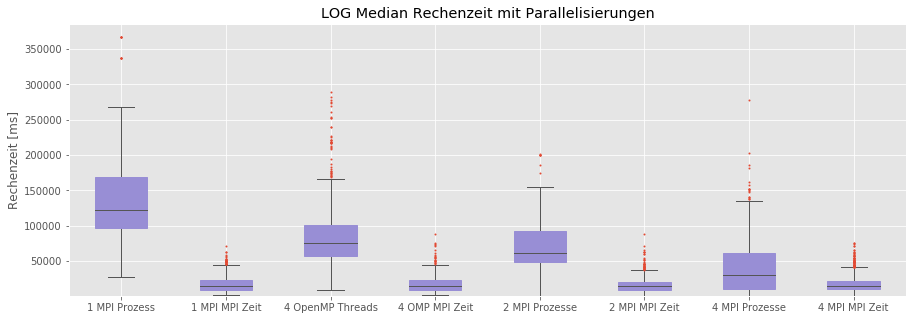

In [7]:
normalT = load_json("./data/data_parallel_normal.json")
ompT = load_json("./data/data_parallel_4_OpenMP.json")
mpiT = load_json("./data/data_parallel_4_MPI.json")
mpi2T = load_json("./data/data_parallel_2_MPI.json")


normalCT, normalMPI = zip(*normalT)
ompCT, ompMPI = zip(*ompT)
mpiCT, mpiMPI = zip(*mpiT)
mpi2CT, mpi2MPI = zip(*mpi2T)


x_ticks = ["1 MPI Prozess", "1 MPI MPI Zeit", "4 OpenMP Threads", '4 OMP MPI Zeit', '2 MPI Prozesse', '2 MPI MPI Zeit', "4 MPI Prozesse", '4 MPI MPI Zeit']
x = np.arange(len(x_ticks))
y = [normalCT, normalMPI, ompCT, ompMPI, mpi2CT, mpi2MPI, mpiCT, mpiMPI]
#yerr = (normalErr, ompErr, mpi2Err, mpiErr)

total_width = 0.8
ind_width = total_width / 2
alteration = np.arange(-(total_width / 2), total_width/2, ind_width)

fig, ax = plt.subplots(figsize=(15,5))

box = ax.boxplot(y, 0,
                    patch_artist= True,
                    medianprops = {'color': '#555555'},
                    boxprops = {'color': '#988ED5', 'facecolor': '#988ED5'},
                    whiskerprops = {'color': '#555555'},
                    capprops = {'color': '#555555'},
                    flierprops = {'markersize': 1.0, 'markerfacecolor': '#E24A33', 'markeredgecolor': '#E24A33'})

ax.set_ylabel('Rechenzeit [ms]')
ax.set_title('LOG Median Rechenzeit mit Parallelisierungen')
ax.set_xticklabels(x_ticks)
#ax.legend()
#plt.yscale('log')
plt.axis([None, None, 1000, None])
#save_fig(fig, 'parallelism_box')
plt.show()


4 OpenMP speedup factor 3.1655205082255256
2 MPI speedup factor: 2.023132963762987
4 MPI speedup factor: 3.961685613922198


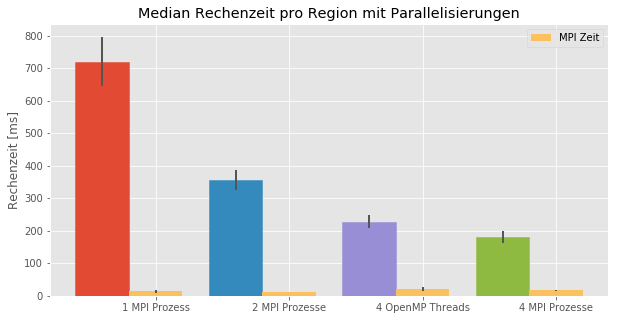

In [6]:
normalT = load_json("./data/data_parallel_normal_2.json")
ompT = load_json("./data/data_parallel_4_OpenMP_2.json")
mpiT = load_json("./data/data_parallel_4_MPI_2.json")
mpi2T = load_json("./data/data_parallel_2_MPI_2.json")

def stat(data):
    a, b = zip(*data)
    a, b = np.asarray(a) / 1e3, np.asarray(b) / 1e3
    m, err = mean_confidence(a, .99)
    m2, err2 = mean_confidence(b, .99)
    return m, err, m2, err2

normal, normalErr, normalMPI, normalMPIerr = stat(normalT)
omp, ompErr, ompMPI, ompMPIerr = stat(ompT)
mpi, mpiErr, mpiMPI, mpiMPIerr = stat(mpiT)
mpi2, mpi2Err, mpi2MPI, mpi2MPIerr = stat(mpi2T)


x_ticks = ["1 MPI Prozess", '2 MPI Prozesse', "4 OpenMP Threads", "4 MPI Prozesse"]
x = np.arange(len(x_ticks))
y = (normal,mpi2,  omp, mpi)
yerr = (normalErr,  mpi2Err, ompErr,mpiErr)


fig, ax = plt.subplots(figsize=(10,5))
total_width = 0.8
ind_width = total_width / 2
alteration = np.arange(-(total_width / 2), total_width/2, ind_width)

barlist = ax.bar(alteration[0] + x, y, align='center', width=ind_width)

barlist[0].set_color('#E24A33')
barlist[1].set_color('#348ABD')
barlist[2].set_color('#988ED5')
barlist[3].set_color('#8EBA42')


yMPI = (normalMPI, mpi2MPI, ompMPI, mpiMPI)
yMPIErr = (normalMPIerr, mpi2MPIerr, ompMPIerr, mpiMPIerr)
ax.bar(alteration[1] + x, yMPI, align='center', color='#FBC15E', width=ind_width, label='MPI Zeit')


ax.errorbar(alteration[0] + x, y, yerr=yerr, color='#555555', ls='none', lw = 2, capthick = 2)
ax.errorbar(alteration[1] + x, yMPI, yerr=yMPIErr, color='#555555', ls='none', lw = 2, capthick = 2)
ax.set_ylabel('Rechenzeit [ms]')
ax.set_title('Median Rechenzeit pro Region mit Parallelisierungen')

ax.set_xticks(np.arange(len(x_ticks)))
ax.set_xticklabels(x_ticks)
ax.legend()
#plt.yscale('log')
save_fig(fig, 'parallelism')

print('4 OpenMP speedup factor', normal / omp)
print('2 MPI speedup factor:', normal / mpi2)
print('4 MPI speedup factor:', normal / mpi)

plt.show()

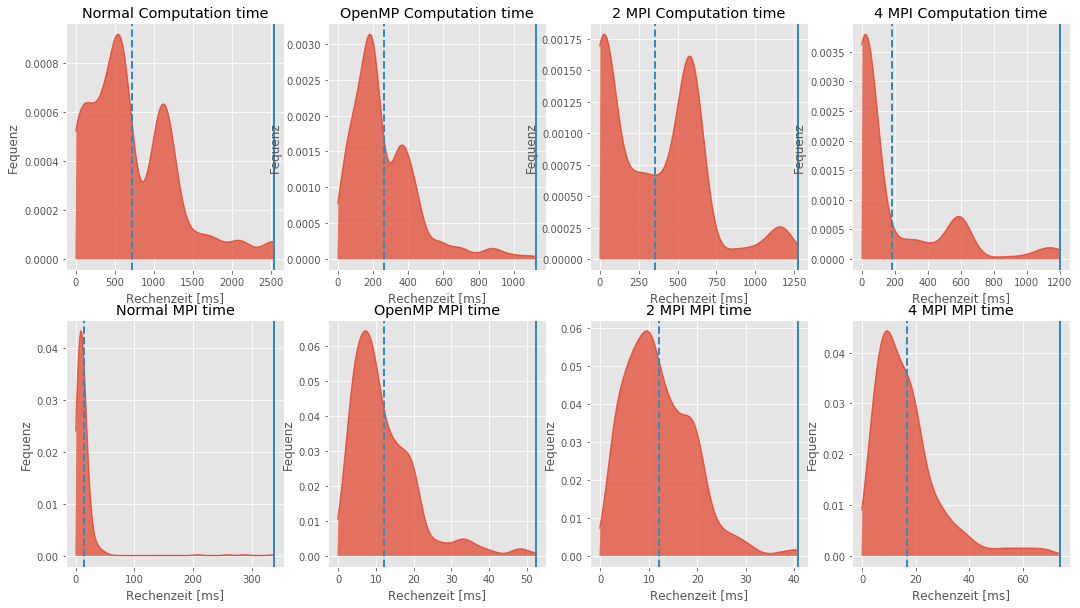

In [9]:
normalCT, normalMPI = zip(*normalT)
ompCT, ompMPI = zip(*ompT)
mpiCT, mpiMPI = zip(*mpiT)
mpi2CT, mpi2MPI = zip(*mpi2T)

normalCT, normalMPI = np.asarray(normalCT) / 1e3, np.asarray(normalMPI) / 1e3
ompCT, ompMPI = np.asarray(ompCT) / 1e3, np.asarray(ompMPI) / 1e3
mpiCT, mpiMPI = np.asarray(mpiCT) / 1e3, np.asarray(mpiMPI) / 1e3
mpi2CT, mpi2MPI = np.asarray(mpi2CT) / 1e3, np.asarray(mpi2MPI) / 1e3


fig, axs = plt.subplots(2, 4, figsize=(18,10))
histogram(axs[0,0], normalCT, 'Rechenzeit [ms]', 'Fequenz', "Normal Computation time")
histogram(axs[0,1], ompCT, 'Rechenzeit [ms]', 'Fequenz', "OpenMP Computation time")
histogram(axs[0,2], mpi2CT, 'Rechenzeit [ms]', 'Fequenz', "2 MPI Computation time")
histogram(axs[0,3], mpiCT, 'Rechenzeit [ms]', 'Fequenz', "4 MPI Computation time")
histogram(axs[1,0], normalMPI, 'Rechenzeit [ms]', 'Fequenz', "Normal MPI time")
histogram(axs[1,1], ompMPI, 'Rechenzeit [ms]', 'Fequenz', "OpenMP MPI time")
histogram(axs[1,2], mpi2MPI, 'Rechenzeit [ms]', 'Fequenz', "2 MPI MPI time")
histogram(axs[1,3], mpiMPI, 'Rechenzeit [ms]', 'Fequenz', "4 MPI MPI time")

plt.show()


## OpenMP mit static schedule

4 OpenMP speedup factor 2.659568794958652
2 MPI speedup factor: 2.023132963762987
4 MPI speedup factor: 3.961685613922198


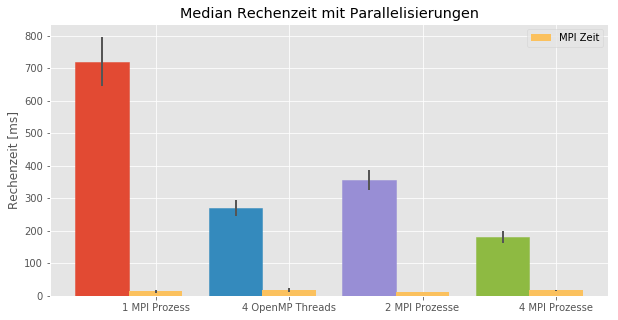

In [5]:
normalT = load_json("./data/data_parallel_normal_2.json")
ompT = load_json("./data/data_parallel_4_OpenMP_2.static.json")
mpiT = load_json("./data/data_parallel_4_MPI_2.json")
mpi2T = load_json("./data/data_parallel_2_MPI_2.json")

def stat(data):
    a, b = zip(*data)
    a, b = np.asarray(a) / 1e3, np.asarray(b) / 1e3
    m, err = mean_confidence(a, .99)
    m2, err2 = mean_confidence(b, .99)
    return m, err, m2, err2
    #return np.mean(a), np.std(a), np.mean(b), np.std(b)

normal, normalErr, normalMPI, normalMPIerr = stat(normalT)
omp, ompErr, ompMPI, ompMPIerr = stat(ompT)
mpi, mpiErr, mpiMPI, mpiMPIerr = stat(mpiT)
mpi2, mpi2Err, mpi2MPI, mpi2MPIerr = stat(mpi2T)


x_ticks = ["1 MPI Prozess", "4 OpenMP Threads", '2 MPI Prozesse', "4 MPI Prozesse"]
x = np.arange(len(x_ticks))
y = (normal, omp, mpi2, mpi)
yerr = (normalErr, ompErr, mpi2Err, mpiErr)


fig, ax = plt.subplots(figsize=(10,5))
total_width = 0.8
ind_width = total_width / 2
alteration = np.arange(-(total_width / 2), total_width/2, ind_width)

barlist = ax.bar(alteration[0] + x, y, align='center', width=ind_width)

barlist[0].set_color('#E24A33')
barlist[1].set_color('#348ABD')
barlist[2].set_color('#988ED5')
barlist[3].set_color('#8EBA42')


yMPI = (normalMPI, ompMPI, mpi2MPI, mpiMPI)
yMPIErr = (normalMPIerr, ompMPIerr, mpi2MPIerr, mpiMPIerr)
ax.bar(alteration[1] + x, yMPI, align='center', color='#FBC15E', width=ind_width, label='MPI Zeit')


ax.errorbar(alteration[0] + x, y, yerr=yerr, color='#555555', ls='none', lw = 2, capthick = 2)
ax.errorbar(alteration[1] + x, yMPI, yerr=yMPIErr, color='#555555', ls='none', lw = 2, capthick = 2)
ax.set_ylabel('Rechenzeit [ms]')
ax.set_title('Median Rechenzeit mit Parallelisierungen')

ax.set_xticks(np.arange(len(x_ticks)))
ax.set_xticklabels(x_ticks)
ax.legend()
#plt.yscale('log')
#save_fig(fig, 'parallelism')

print('4 OpenMP speedup factor', normal / omp)
print('2 MPI speedup factor:', normal / mpi2)
print('4 MPI speedup factor:', normal / mpi)

plt.show()